In [1]:
import pandas as pd
import os.path
from helpers.clustering import *

In [2]:
file_path = 'cache/data.parquet'
if not os.path.isfile(file_path):
    file_path = 'cache/data.csv'
    df = pd.read_csv(file_path)
else:
    df = pd.read_parquet(file_path)
    
genres_df = pd.read_parquet('cache/genres.parquet')
languages_df = pd.read_parquet('cache/languages.parquet')
countries_df = pd.read_parquet('cache/countries.parquet')

ethnicities_df = pd.get_dummies(df['actor_ethnicity'], dtype=int, drop_first=True)

In [3]:
print(df.columns)
x_numeric = df.drop(columns=['languages', 'genres', 'countries', 
                  'title', 'movie_identifier', 'parsed_actor_name', 'actor_identifier', 'identifier', 
                  'category', 'winner', 'oscar_nominated',
                  'actor_gender', 'actor_ethnicity'])
x_numeric['isMale'] = df['actor_gender'].apply(lambda x: 1 if x == 'M' else 0)
print(x_numeric.dtypes)

Index(['title', 'box_office_revenue', 'runtime', 'languages', 'countries',
       'genres', 'movie_identifier', 'actor_gender', 'actor_height',
       'actor_ethnicity', 'actor_age', 'parsed_actor_name', 'actor_identifier',
       'identifier', 'category', 'winner', 'oscar_nominated', 'year',
       'average_rating', 'number_of_votes', 'number_of_movies_starred_in',
       'average_rating_previous_movies',
       'average_box_office_revenue_previous_movies'],
      dtype='object')
box_office_revenue                              int64
runtime                                         int64
actor_height                                  float64
actor_age                                       int64
year                                            int64
average_rating                                float64
number_of_votes                                 int64
number_of_movies_starred_in                     int64
average_rating_previous_movies                float64
average_box_office_revenue_p

In [4]:
all_merged_df = x_numeric.merge(genres_df, left_index=True, right_index=True).merge(languages_df, left_index=True, right_index=True).merge(countries_df, left_index=True, right_index=True)

In [5]:
df['target'] = df.apply(lambda x: make_targets(x['oscar_nominated'], x['winner']), axis=1)

In [6]:
not_nominated = df.loc[df['oscar_nominated'] != True].index
lost = df.loc[(df['oscar_nominated'] == True) & (df['winner'] == False)].index
won = df.loc[(df['oscar_nominated'] == True) & (df['winner'] == True)].index
len(not_nominated) + len(won) + len(lost)  

23812

# Clustering of actors based on all available numeric features

This includes the augmented features about actors past oscar experience.

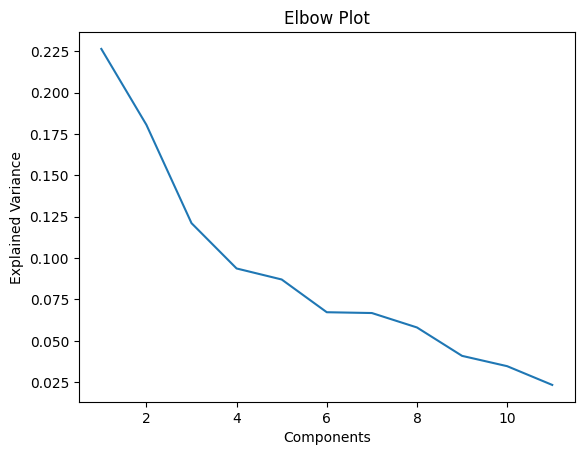

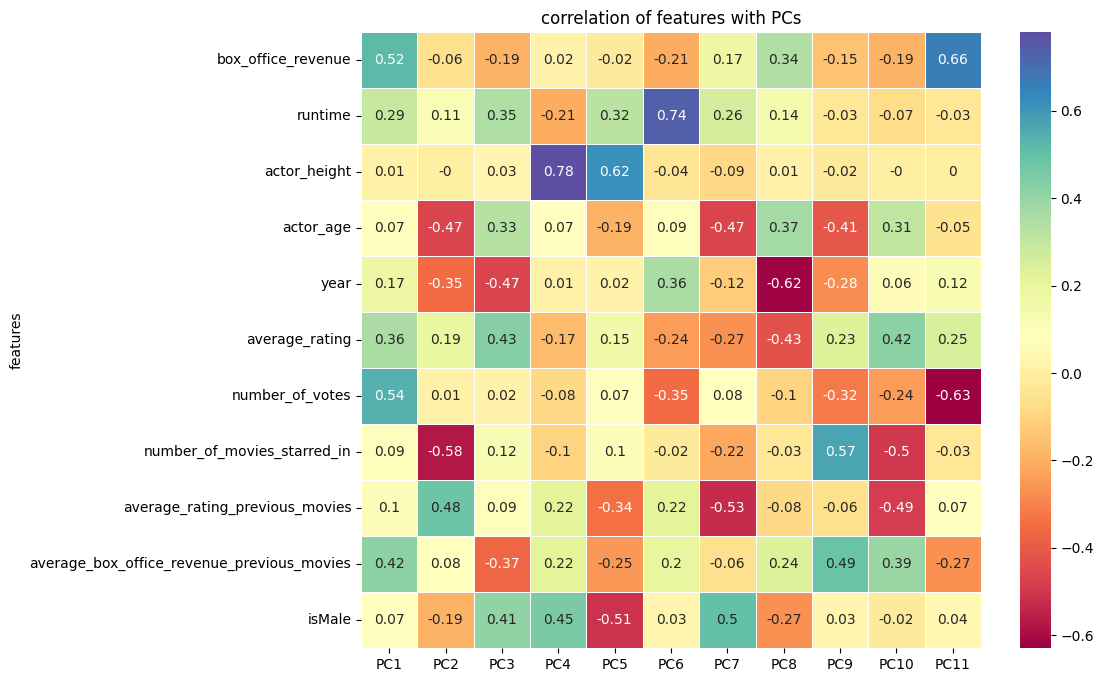

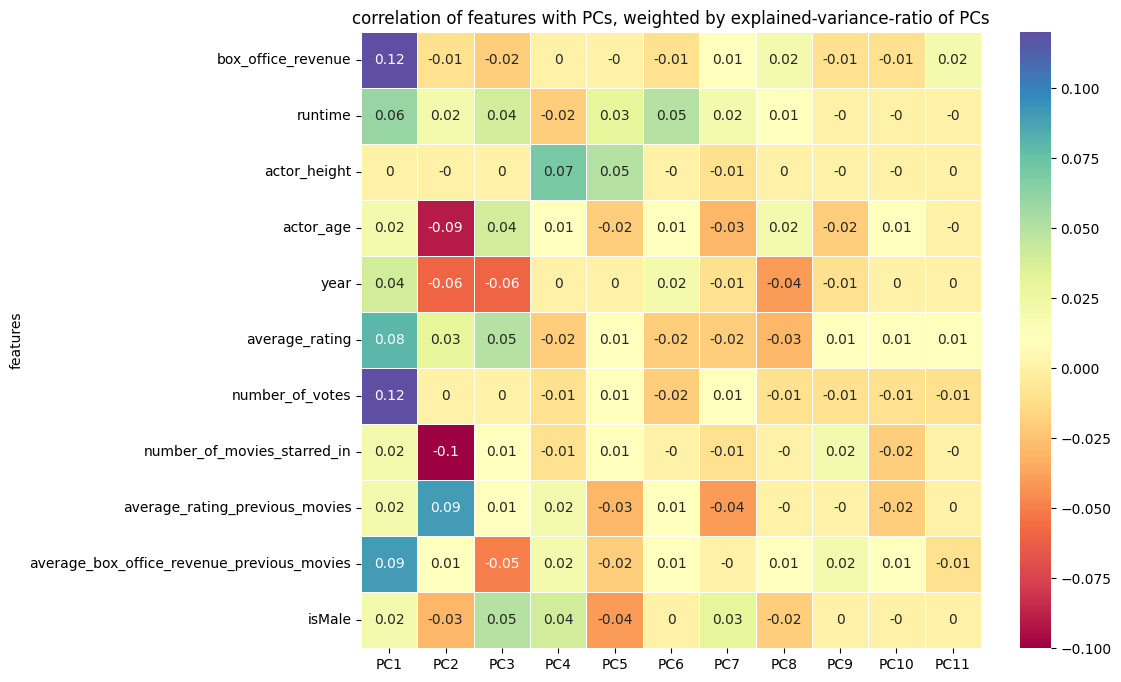

/home/tkoch/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


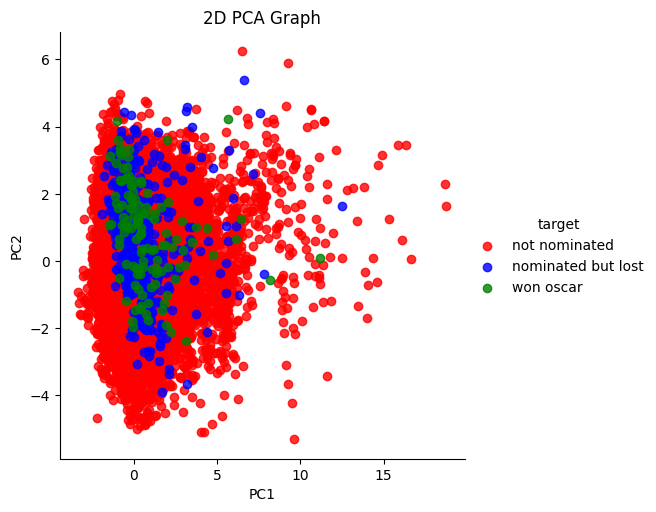

In [7]:
x_numeric_pca_res, x_numeric_pca_out = run_pca_analysis(x_numeric)
elbow_plot(x_numeric_pca_out)
pca_heatmap(x_numeric_pca_out, x_numeric, False, round=2, title='correlation of features with PCs')
pca_heatmap(x_numeric_pca_out, x_numeric, True, round=2, title='correlation of features with PCs, weighted by explained-variance-ratio of PCs')
pca_scatter_plot(x_numeric_pca_res, df['target'])


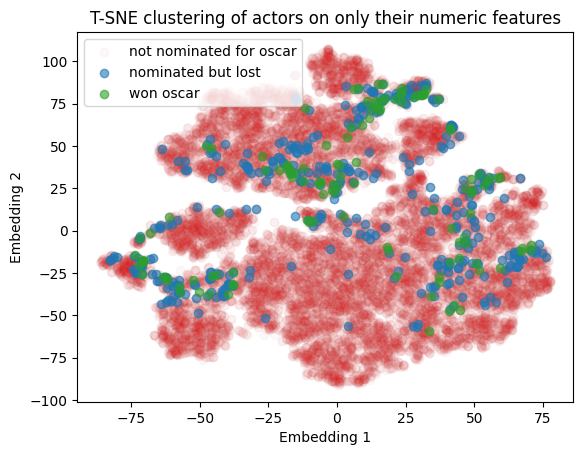

In [8]:
x_numeric_tsne_embeddings = run_tsne_analysis(x_numeric, 50, scale=True, return_df=True)
plot_clusters(x_numeric_tsne_embeddings, not_nominated, lost, won, title=('T-SNE clustering of actors on only their numeric features'))


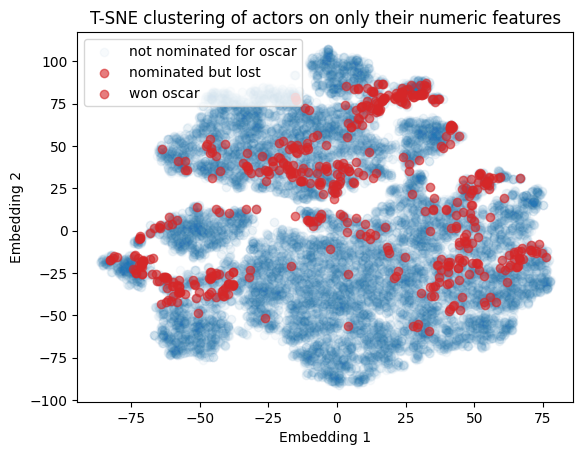

In [9]:
plot_clusters(x_numeric_tsne_embeddings, not_nominated, lost, won, cs=['tab:blue', 'tab:red', 'tab:red'], title=('T-SNE clustering of actors on only their numeric features'))


# Clustering actors on only non-augmented numerical features



In [10]:
x_numeric_wo_augmented = x_numeric.drop(columns=['number_of_movies_starred_in', 'average_rating_previous_movies', 'average_box_office_revenue_previous_movies'])
x_numeric_wo_augmented.columns

Index(['box_office_revenue', 'runtime', 'actor_height', 'actor_age', 'year',
       'average_rating', 'number_of_votes', 'isMale'],
      dtype='object')

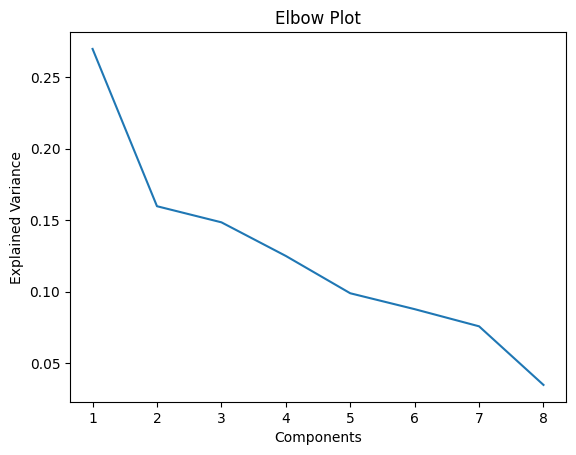

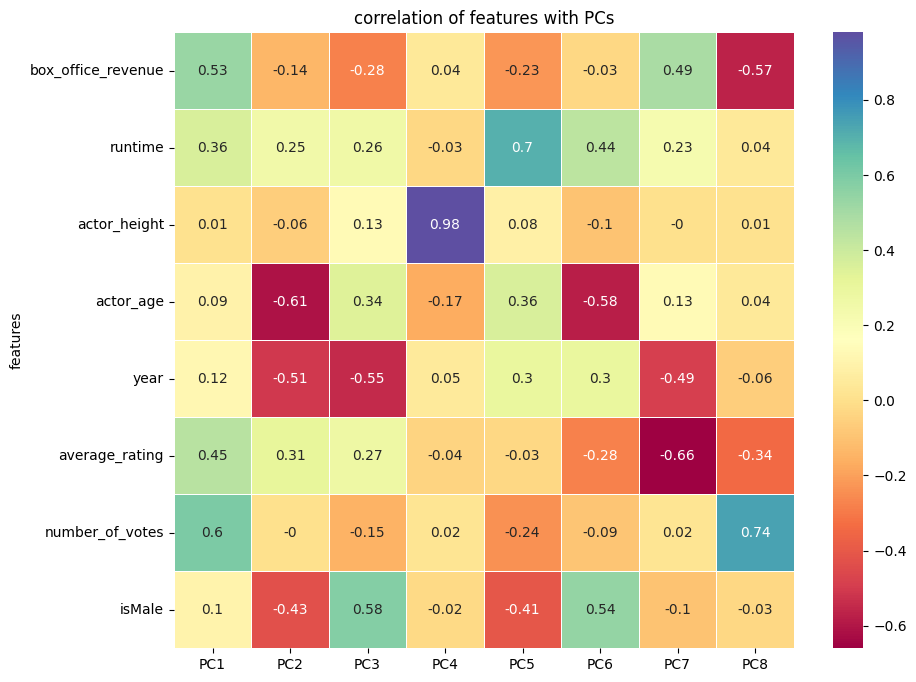

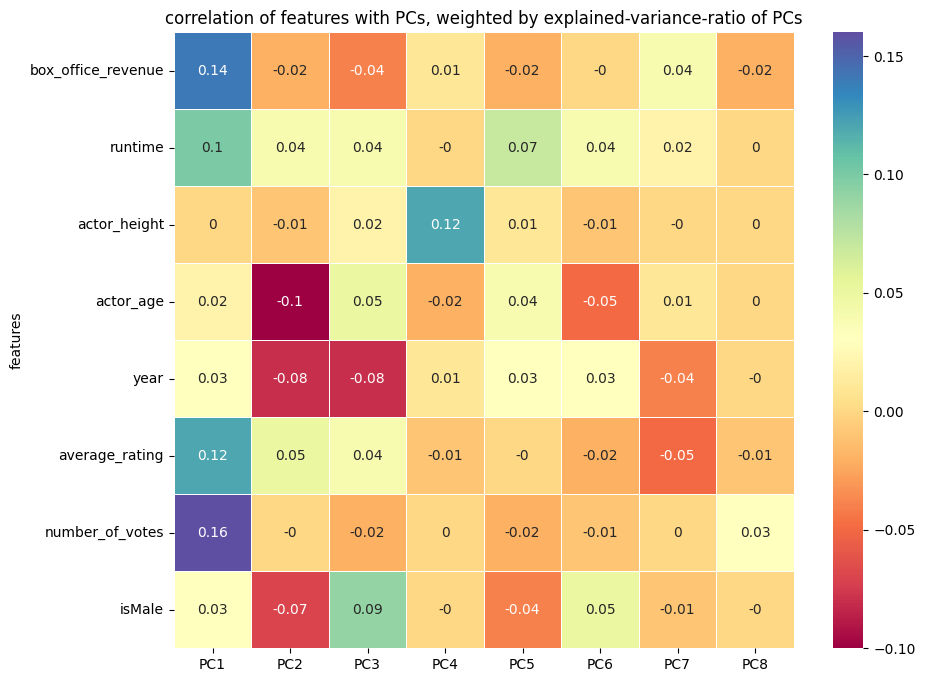

/home/tkoch/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


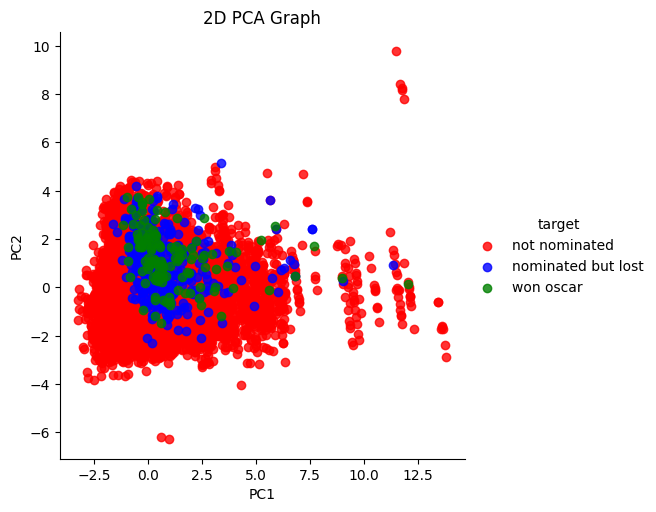

In [11]:
x_numeric_wo_augmented_pca_res, x_numeric_wo_augmented_pca_out = run_pca_analysis(x_numeric_wo_augmented)
elbow_plot(x_numeric_wo_augmented_pca_out)
pca_heatmap(x_numeric_wo_augmented_pca_out, x_numeric_wo_augmented, False, round=2, title='correlation of features with PCs')
pca_heatmap(x_numeric_wo_augmented_pca_out, x_numeric_wo_augmented, True, round=2, title='correlation of features with PCs, weighted by explained-variance-ratio of PCs')
pca_scatter_plot(x_numeric_wo_augmented_pca_res, df['target'])


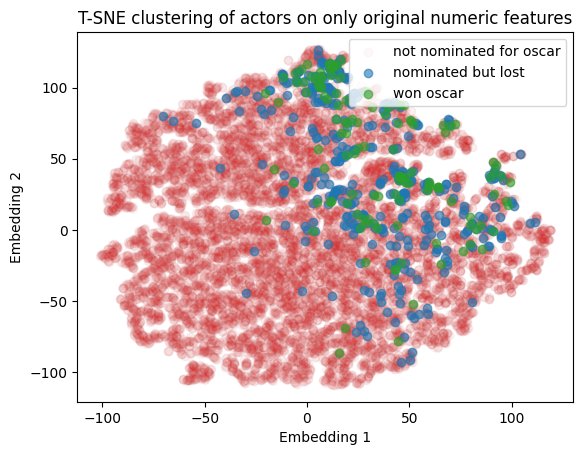

In [12]:
x_numeric_wo_tsne_embeddings = run_tsne_analysis(x_numeric_wo_augmented, 20, scale=True, return_df=True)
plot_clusters(x_numeric_wo_tsne_embeddings, not_nominated, lost, won, title=('T-SNE clustering of actors on only original numeric features'))


In [24]:
actor_features = pd.DataFrame(x_numeric, columns=['actor_height', 'actor_age', 'isMale',], index=x_numeric.index).merge(ethnicities_df.loc[:, get_top_n_columns_by_sum(ethnicities_df)], left_index=True, right_index=True)
actor_features.columns

Index(['actor_height', 'actor_age', 'isMale', '/m/0x67', '/m/041rx',
       '/m/02w7gg', '/m/033tf_', '/m/0xnvg', '/m/07hwkr', '/m/07bch9',
       '/m/03bkbh', '/m/02ctzb', '/m/044038p'],
      dtype='object')

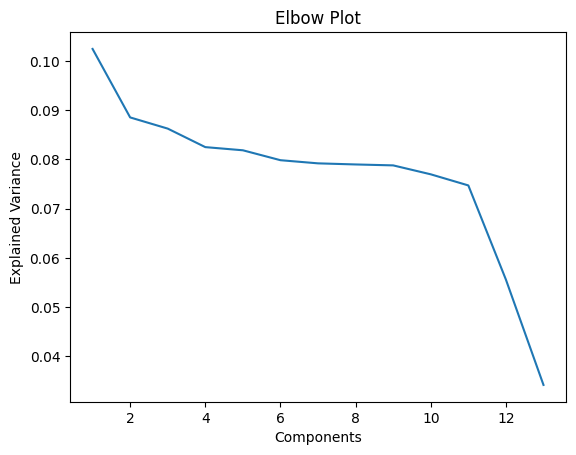

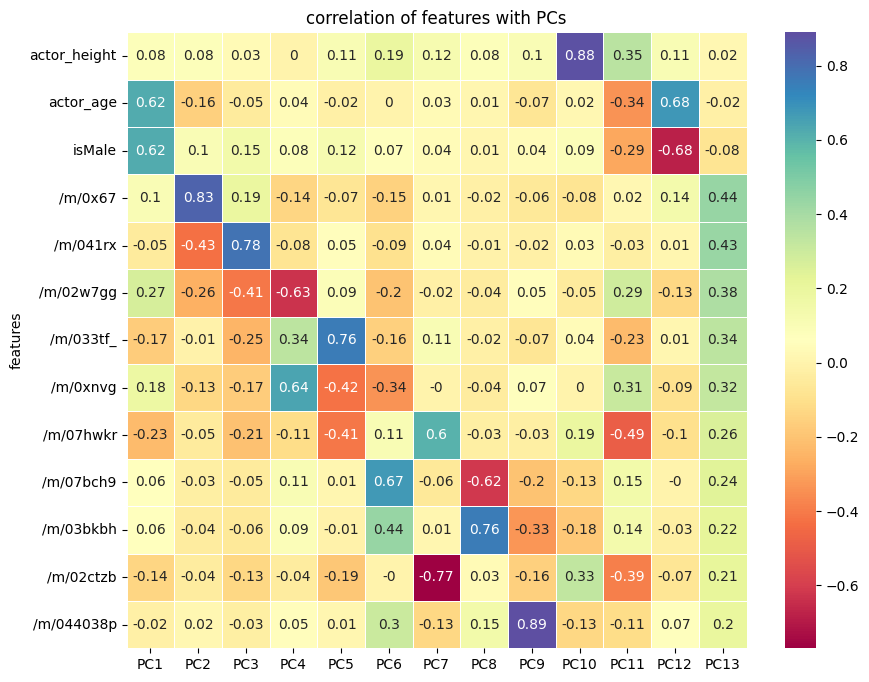

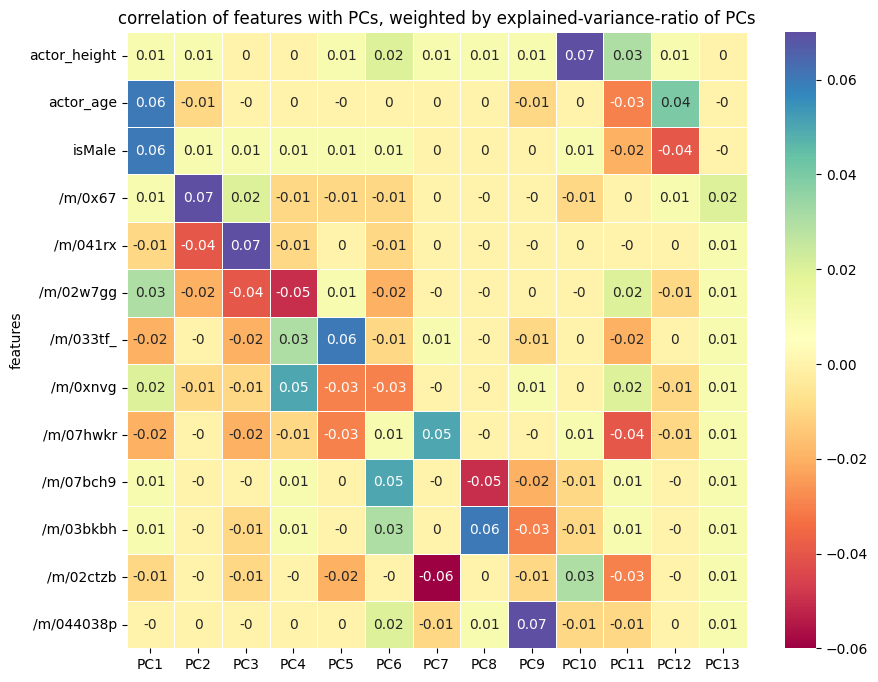

/home/tkoch/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


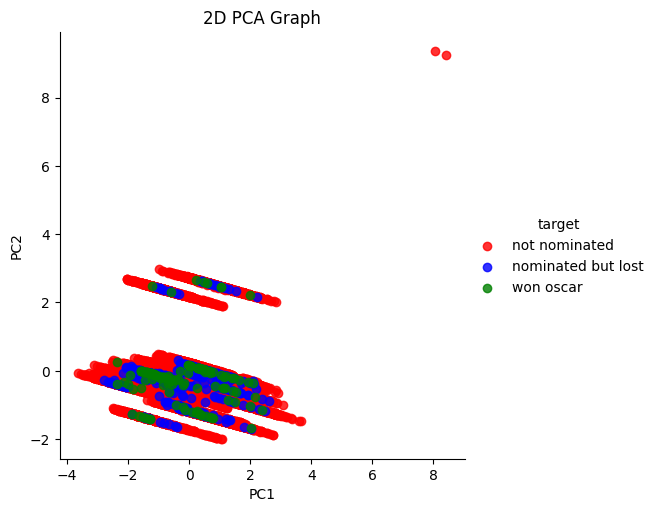

In [25]:
actor_features_pca_res, actor_features_pca_out = run_pca_analysis(actor_features)
elbow_plot(actor_features_pca_out)
pca_heatmap(actor_features_pca_out, actor_features, False, round=2, title='correlation of features with PCs')
pca_heatmap(actor_features_pca_out, actor_features, True, round=2, title='correlation of features with PCs, weighted by explained-variance-ratio of PCs')
pca_scatter_plot(actor_features_pca_res, df['target'])


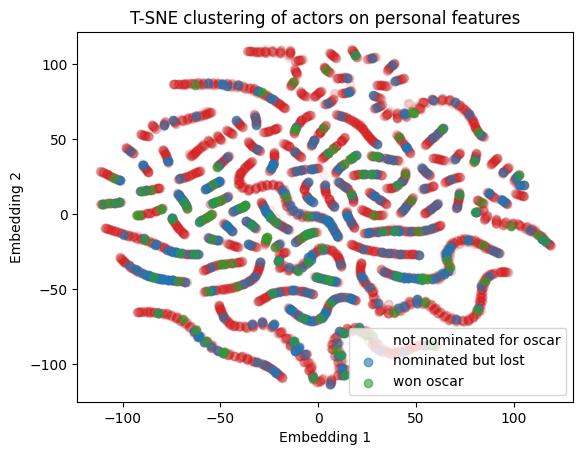

In [26]:
actor_features_tsne_embeddings = run_tsne_analysis(actor_features, 50, scale=True, return_df=True)
plot_clusters(actor_features_tsne_embeddings, not_nominated, lost, won, title=('T-SNE clustering of actors on personal features'))


In [13]:
actor_features = pd.DataFrame(x_numeric, columns=['actor_height', 'actor_age', 'isMale', 'number_of_movies_starred_in', 'average_rating_previous_movies', 'average_box_office_revenue_previous_movies'], index=x_numeric.index).merge(ethnicities_df.loc[:, get_top_n_columns_by_sum(ethnicities_df)], left_index=True, right_index=True)
actor_features.columns

Index(['actor_height', 'actor_age', 'isMale', 'number_of_movies_starred_in',
       'average_rating_previous_movies',
       'average_box_office_revenue_previous_movies', '/m/0x67', '/m/041rx',
       '/m/02w7gg', '/m/033tf_', '/m/0xnvg', '/m/07hwkr', '/m/07bch9',
       '/m/03bkbh', '/m/02ctzb', '/m/044038p'],
      dtype='object')

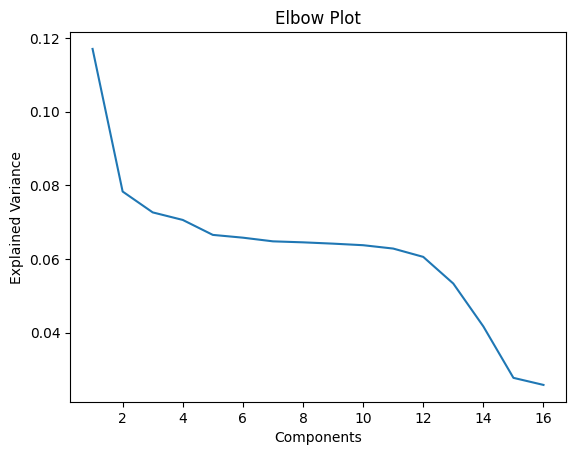

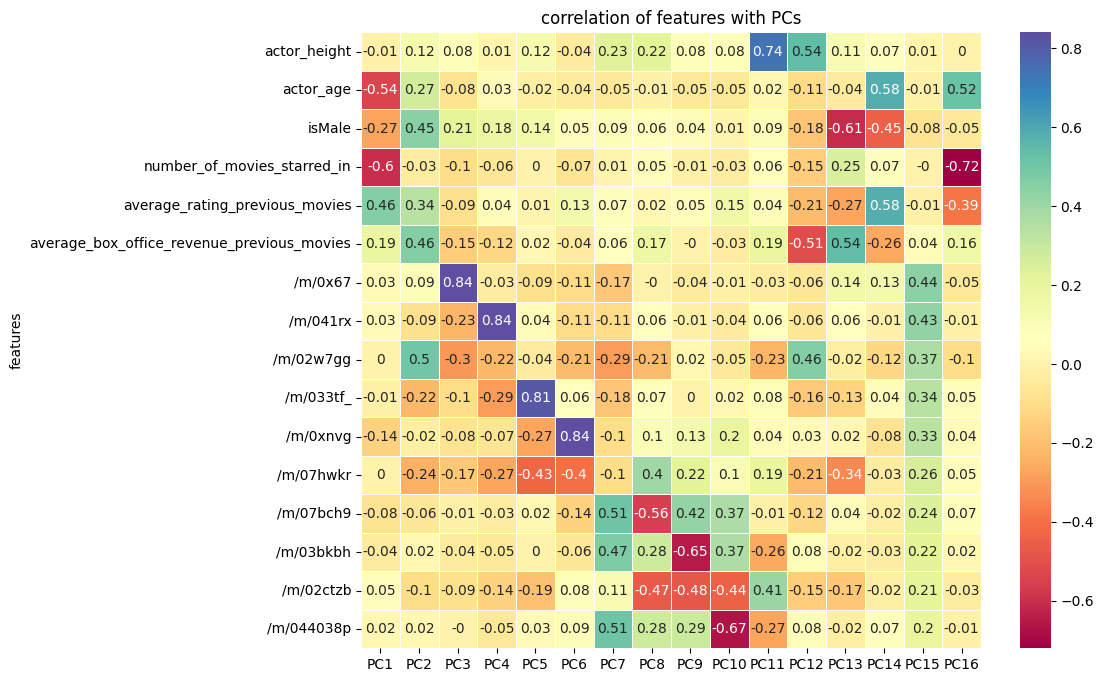

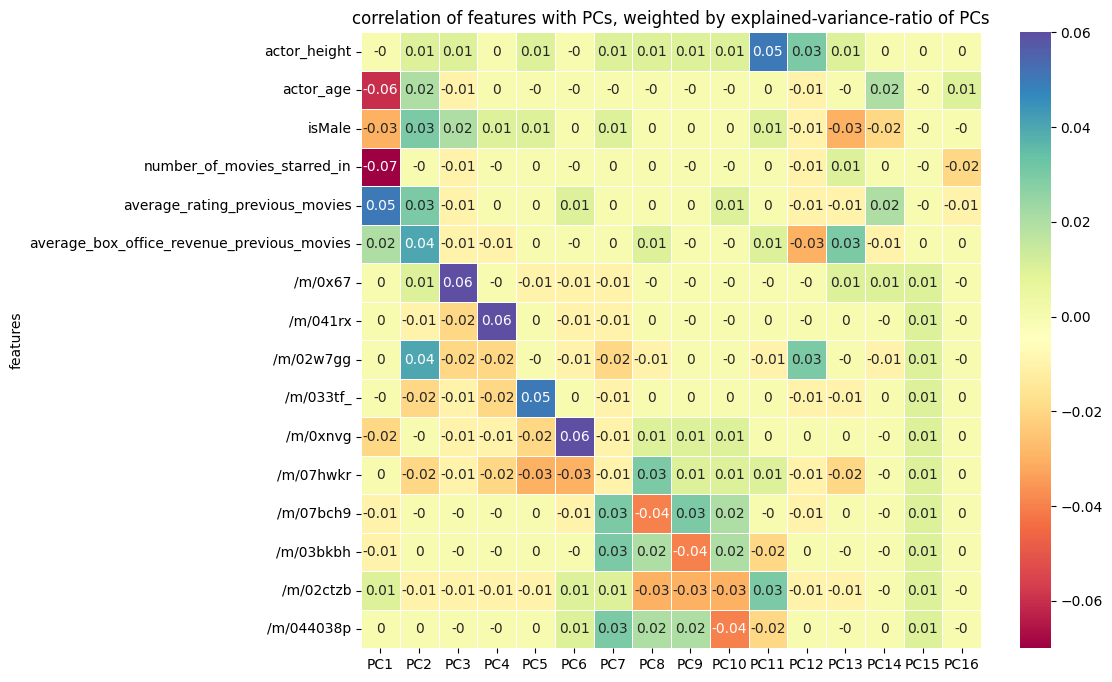

/home/tkoch/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


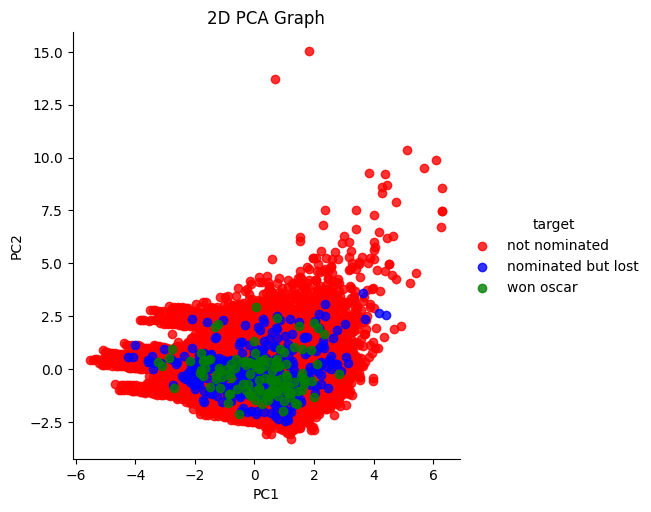

In [14]:
actor_features_pca_res, actor_features_pca_out = run_pca_analysis(actor_features)
elbow_plot(actor_features_pca_out)
pca_heatmap(actor_features_pca_out, actor_features, False, round=2, title='correlation of features with PCs')
pca_heatmap(actor_features_pca_out, actor_features, True, round=2, title='correlation of features with PCs, weighted by explained-variance-ratio of PCs')
pca_scatter_plot(actor_features_pca_res, df['target'])


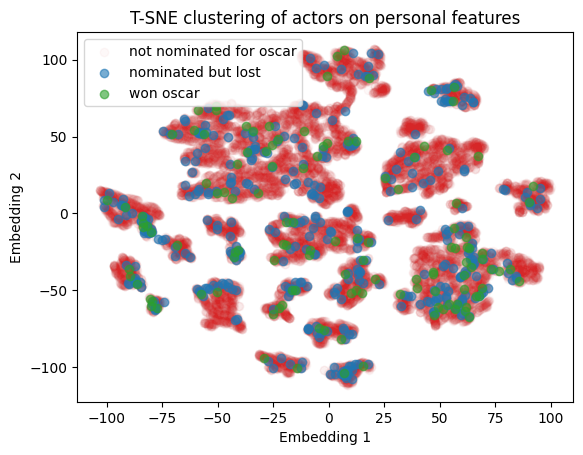

In [15]:
actor_features_tsne_embeddings = run_tsne_analysis(actor_features, 50, scale=True, return_df=True)
plot_clusters(actor_features_tsne_embeddings, not_nominated, lost, won, title=('T-SNE clustering of actors on personal features'))


In [16]:
actor_features = pd.DataFrame(x_numeric, columns=['actor_height', 'actor_age', 'isMale', 'number_of_movies_starred_in', 'average_rating_previous_movies', 'average_box_office_revenue_previous_movies'], index=x_numeric.index).merge(ethnicities_df, left_index=True, right_index=True)
actor_features.columns

Index(['actor_height', 'actor_age', 'isMale', 'number_of_movies_starred_in',
       'average_rating_previous_movies',
       'average_box_office_revenue_previous_movies', '/m/012f86', '/m/01336l',
       '/m/013b6_', '/m/013b7g',
       ...
       '/m/0g96wd', '/m/0gf5k1', '/m/0gkxl2', '/m/0h1nk0k', '/m/0h2138',
       '/m/0h6mqq9', '/m/0h8mzsl', '/m/0j4w_', '/m/0x67', '/m/0xnvg'],
      dtype='object', length=285)

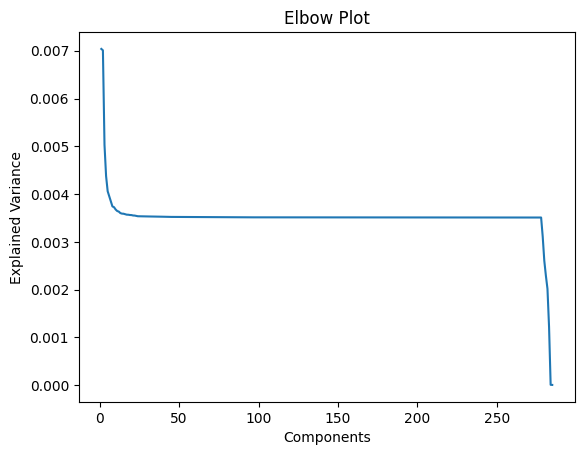

/home/tkoch/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


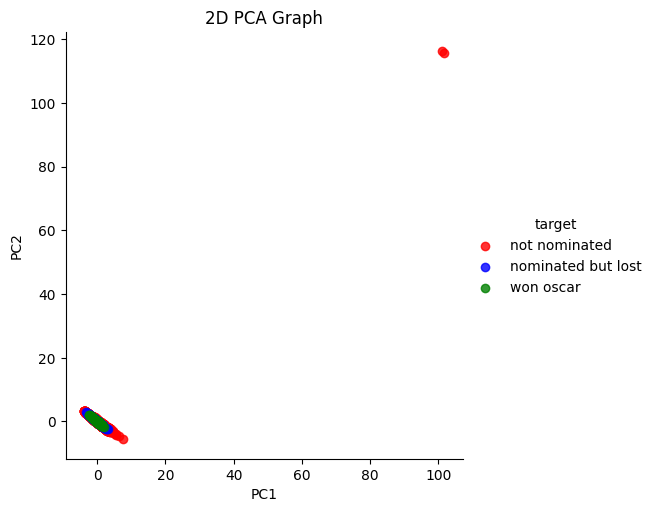

In [17]:
actor_features_pca_res, actor_features_pca_out = run_pca_analysis(actor_features)
elbow_plot(actor_features_pca_out)
# pca_heatmap(actor_features_pca_out, actor_features, False, round=2, title='correlation of features with PCs')
# pca_heatmap(actor_features_pca_out, actor_features, True, round=2, title='correlation of features with PCs, weighted by explained-variance-ratio of PCs')
pca_scatter_plot(actor_features_pca_res, df['target'])


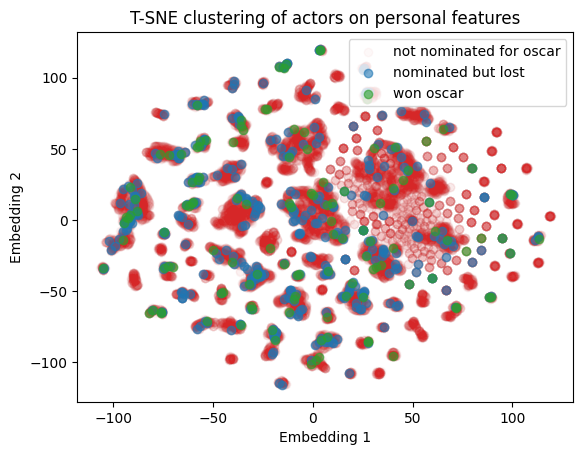

In [18]:
actor_features_tsne_embeddings = run_tsne_analysis(actor_features, 50, scale=True, return_df=True)
plot_clusters(actor_features_tsne_embeddings, not_nominated, lost, won, title=('T-SNE clustering of actors on personal features'))


In [20]:
actor_features.columns

Index(['actor_height', 'actor_age', 'isMale', 'number_of_movies_starred_in',
       'average_rating_previous_movies',
       'average_box_office_revenue_previous_movies', '/m/012f86', '/m/01336l',
       '/m/013b6_', '/m/013b7g',
       ...
       '/m/0g96wd', '/m/0gf5k1', '/m/0gkxl2', '/m/0h1nk0k', '/m/0h2138',
       '/m/0h6mqq9', '/m/0h8mzsl', '/m/0j4w_', '/m/0x67', '/m/0xnvg'],
      dtype='object', length=285)

In [21]:
actor_features_no_eth = pd.DataFrame(x_numeric, 
                                     columns=['actor_height', 'actor_age', 'isMale', 'number_of_movies_starred_in', 'average_rating_previous_movies', 'average_box_office_revenue_previous_movies'], 
                                     index=x_numeric.index)

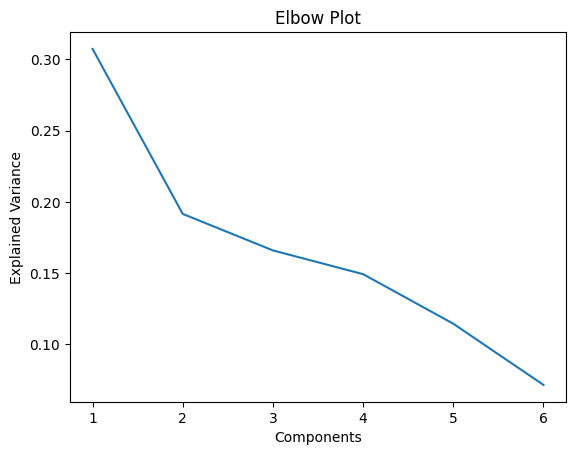

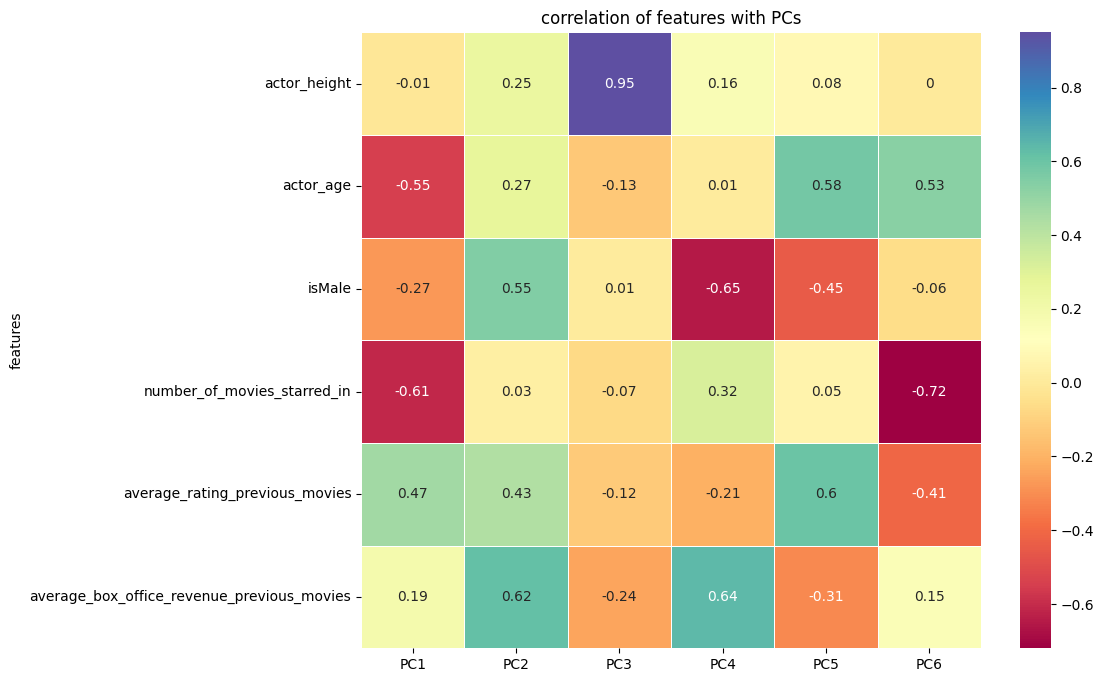

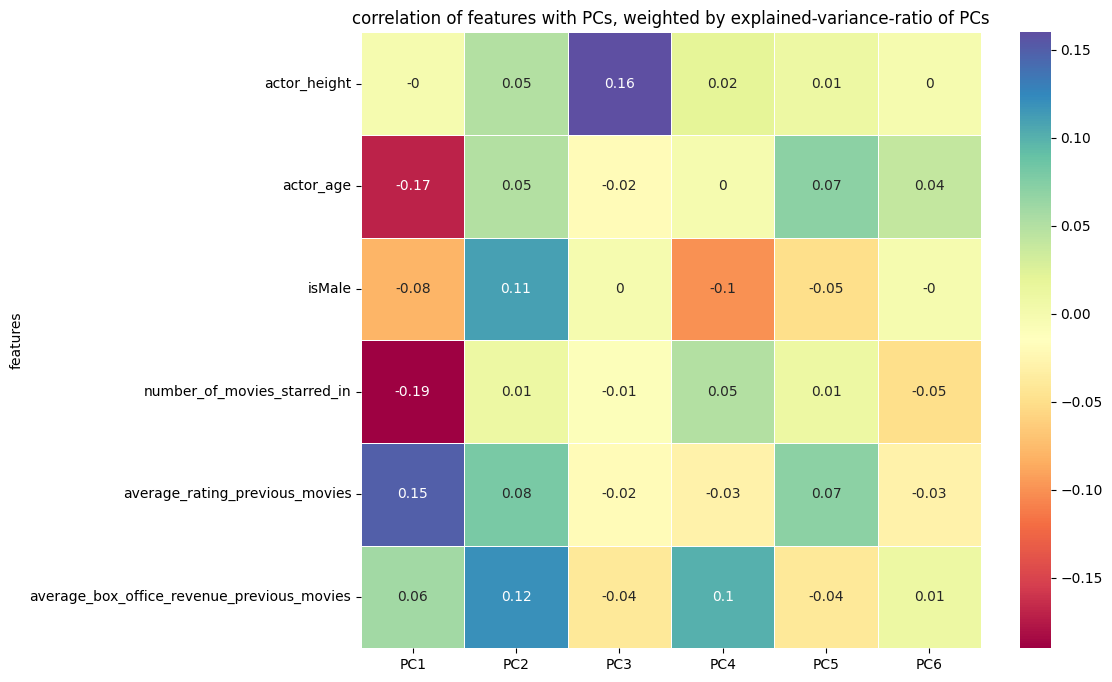

/home/tkoch/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


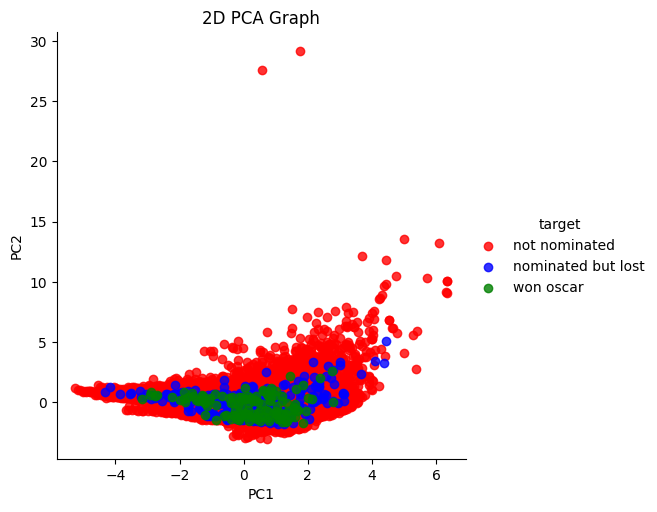

In [22]:
actor_features_pca_res, actor_features_pca_out = run_pca_analysis(actor_features_no_eth)
elbow_plot(actor_features_pca_out)
pca_heatmap(actor_features_pca_out, actor_features_no_eth, False, round=2, title='correlation of features with PCs')
pca_heatmap(actor_features_pca_out, actor_features_no_eth, True, round=2, title='correlation of features with PCs, weighted by explained-variance-ratio of PCs')
pca_scatter_plot(actor_features_pca_res, df['target'])


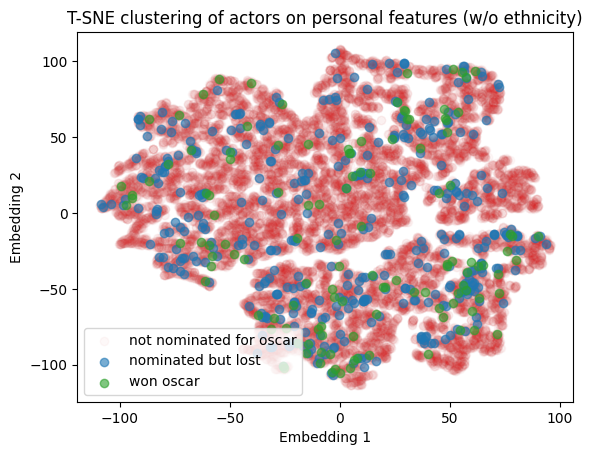

In [27]:
actor_features_tsne_embeddings = run_tsne_analysis(actor_features_no_eth, 30, scale=True, return_df=True)
plot_clusters(actor_features_tsne_embeddings, not_nominated, lost, won, title=('T-SNE clustering of actors on personal features (w/o ethnicity)'))
